### Imports

In [ ]:
import pytensor.tensor as pt
import pytensor.sparse as sparse
import pytensor
import pymc as pm
import numpy as np
import patsy
import scipy.sparse
import scipy
import arviz as az
import os
import boto3
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from dotenv import load_dotenv
from pathlib import Path

load_dotenv()

bucket_name = "duke-research"
bucket_prefix = ""
file_name_inputs = "inputs.npz"
file_name_gpkg = "final.gpkg"
file_name_trace = "trace-revise.nc"

DATA_DIR = Path("data")
VISUALS_DIR = Path("visuals")
TRACE_PATH = DATA_DIR / file_name_trace
SAVE_FIGURES = False

pd.set_option("display.precision", 3)


### Load data

#### Retrieve from S3

In [65]:
files_to_download = [
    file_name_inputs,
    file_name_gpkg,
    file_name_trace
]

for fn in files_to_download:
    if os.path.exists(DATA_DIR / fn):
        print(f"✓ {fn} already exists")
        continue

    print(f"Downloading {fn} from S3...")
    s3 = boto3.client('s3')
    s3.download_file(bucket_name, fn, DATA_DIR / fn)
    print(f"✓ Successfully downloaded {fn}")


✓ inputs.npz already exists
✓ final.gpkg already exists
✓ trace-revise.nc already exists


In [66]:
final_gdf = gpd.read_file(DATA_DIR / file_name_gpkg)
loaded_data = np.load(DATA_DIR /  file_name_inputs)
W = scipy.sparse.csr_matrix((loaded_data['W_data'], loaded_data['W_indices'], loaded_data['W_indptr']))
X = loaded_data['X']
y = loaded_data['y']
coords = loaded_data['coords']
pretty_predictor_cols = loaded_data['pretty_predictor_cols']

W_sym = W + W.T
W_sym = (W_sym > 0).astype(float)

### Analyze trace (run after downloading trace, if trace created remotely)

In [67]:
trace = az.from_netcdf(TRACE_PATH)
final_gdf = gpd.read_file(DATA_DIR / "modeling_inputs"/ 'final_gdf.gpkg')

is_used = final_gdf.huc12.isin(trace.posterior['obs_id'].values)
final_gdf_subset = final_gdf.loc[is_used]
print(f"Trace loaded from disk; {is_used.mean():.2%} of the data used in the model")

Trace loaded from disk; 9.98% of the data used in the model


### Forest plot for coefficients

#### NLCD coefficients

In [68]:
col_groups = {
    'nlcd': [
        'Open Water (%)', 'Perennial Ice/Snow (%)',
        'Developed, Open Space (%)', 'Developed, Low Intensity (%)',
        'Developed, Medium Intensity (%)', 'Developed, High Intensity (%)',
        'Barren Land (%)', 'Deciduous Forest (%)', 'Evergreen Forest (%)',
        'Mixed Forest (%)', 'Shrub/Scrub (%)', 'Grassland/Herbaceous (%)',
        'Woody Wetlands (%)', 'Emergent Herbaceous Wetlands (%)'
    ],
    'litho': [
        "Carbonate (%)",
        "Non-carbonate (%)",
        "Alkaline intrusive (%)",
        "Silicic residual (%)",
        "Extrusive volcanic (%)",
        "Colluvial sediment (%)",
        "Glacial till clay (%)",
        "Glacial till loam (%)",
        "Glacial till coarse (%)",
        "Glacial lake sediment fine (%)",
        "Glacial outwash coarse (%)",
        "Hydric (%)",
        "Eolian sediment coarse (%)",
        "Eolian sediment fine (%)",
        "Saline lake sediment (%)",
        "Alluvium and coastal sediment fine (%)",
        "Coastal sediment coarse (%)"
        ],
    'cdl':[
        'Corn (%)', 'Cotton (%)',
        'Rice (%)', 'Sorghum (%)', 'Soybeans (%)', 'Sunflower (%)',
        'Barley (%)', 'Durum Wheat (%)', 'Spring Wheat (%)', 'Winter Wheat (%)',
        'Other Small Grains (%)', 'Double Crop Winter Wheat/Soybeans (%)',
        'Oats (%)', 'Canola (%)', 'Flaxseed (%)', 'Alfalfa (%)',
        'Sugarbeets (%)', 'Dry Beans (%)', 'Potatoes (%)', 'Other Crops (%)',
        'Lentils (%)', 'Peas (%)'
        ],
    'litho_indicators': [
        'Carbonate (Indicator)',
        'Non-carbonate (Indicator)',
        'Alkaline intrusive (Indicator)',
        'Silicic residual (Indicator)',
        'Extrusive volcanic (Indicator)',
        'Colluvial sediment (Indicator)',
        'Glacial till clay (Indicator)',
        'Glacial till loam (Indicator)',
        'Glacial till coarse (Indicator)',
        'Glacial lake sediment fine (Indicator)',
        'Glacial outwash coarse (Indicator)',
        'Hydric (Indicator)',
        'Eolian sediment coarse (Indicator)',
        'Eolian sediment fine (Indicator)',
        'Saline lake sediment (Indicator)',
        'Alluvium and coastal sediment fine (Indicator)',
        'Coastal sediment coarse (Indicator)'
        ],
    "nlcd_indicators": [
         'Grassland/Herbaceous (Indicator)',
       'Emergent Herbaceous Wetlands (Indicator)',
       'Deciduous Forest (Indicator)', 'Shrub/Scrub (Indicator)',
       'Barren Land (Indicator)', 'Evergreen Forest (Indicator)',
       'Developed, Open Space (Indicator)', 'Mixed Forest (Indicator)',
       'Open Water (Indicator)', 'Developed, Low Intensity (Indicator)',
       'Developed, Medium Intensity (Indicator)',
       'Developed, High Intensity (Indicator)', 'Woody Wetlands (Indicator)'
    ],
    'cdl_indicators': [
        'Corn (Indicator)', 'Cotton (Indicator)',
        'Rice (Indicator)', 'Sorghum (Indicator)', 'Soybeans (Indicator)',
        'Sunflower (Indicator)', 'Barley (Indicator)',
        'Durum Wheat (Indicator)', 'Spring Wheat (Indicator)',
        'Winter Wheat (Indicator)', 'Other Small Grains (Indicator)',
        'Double Crop Winter Wheat/Soybeans (Indicator)', 'Oats (Indicator)',
        'Canola (Indicator)', 'Flaxseed (Indicator)', 'Alfalfa (Indicator)',
        'Sugarbeets (Indicator)', 'Dry Beans (Indicator)',
        'Potatoes (Indicator)', 'Other Crops (Indicator)',
        'Lentils (Indicator)', 'Peas (Indicator)'
    ]

}

for col_group, cols in col_groups.items():
    draws = trace.posterior.z.loc[:, :, 'global_mean', cols]
    mean_df = pd.DataFrame(index=cols) \
    .assign(mean=draws.mean(dim=('chain', 'draw'))) \
    .assign(lower_5=draws.quantile(0.05, dim=('chain', 'draw'))) \
    .assign(upper_95=draws.quantile(0.95, dim=('chain', 'draw'))) \
    .assign(significant=lambda df: ~((df['lower_5'] <= 0) & (df['upper_95'] >= 0))) \
    .sort_values(['significant', 'mean'], ascending=[False, False])

    print(mean_df)

                                   mean  lower_5  upper_95  significant
Grassland/Herbaceous (%)         -0.180   -0.368    -0.019         True
Developed, Open Space (%)        -2.521   -4.276    -0.533         True
Developed, High Intensity (%)     0.407   -1.182     1.837        False
Developed, Medium Intensity (%)   0.159   -0.567     0.895        False
Deciduous Forest (%)              0.143   -0.153     0.488        False
Barren Land (%)                   0.077   -0.252     0.382        False
Woody Wetlands (%)                0.036   -0.231     0.323        False
Perennial Ice/Snow (%)            0.013   -0.756     0.742        False
Evergreen Forest (%)             -0.141   -0.347     0.054        False
Shrub/Scrub (%)                  -0.147   -0.352     0.014        False
Mixed Forest (%)                 -0.167   -0.556     0.133        False
Emergent Herbaceous Wetlands (%) -0.179   -0.579     0.124        False
Developed, Low Intensity (%)     -0.393   -1.403     0.437      

#### Plot of spatial effect

/tmp/ipykernel_1973035/2226241412.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  final_gdf.centroid.x[is_used], final_gdf.centroid.y[is_used],


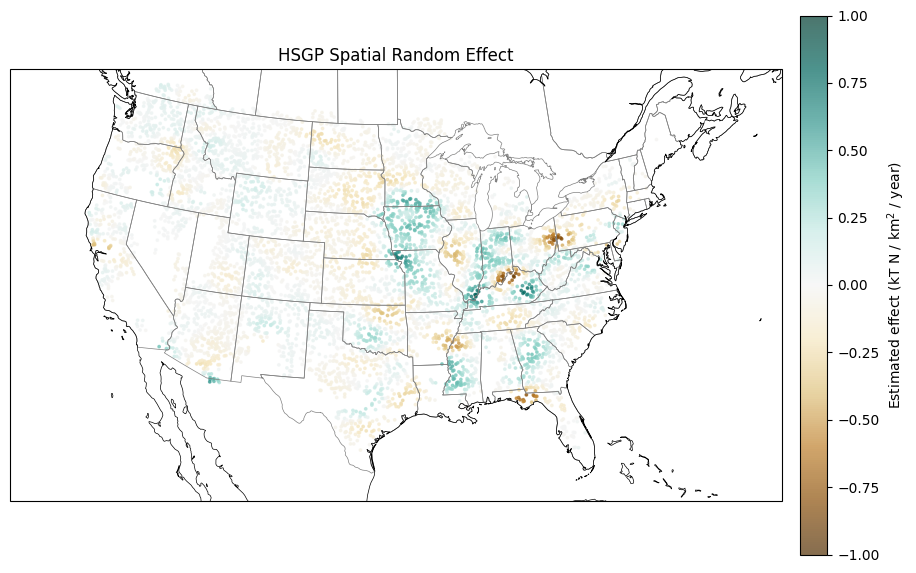

In [69]:
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

plt.figure(figsize=(12, 7))

# Create a map with appropriate projection
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=39))

# Add state boundaries and coastlines
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

# Create colormap for spatial effects
norm = Normalize(vmin=-1, vmax=1)

# Get spatial effects values from the trace
spatial_effects = trace.posterior['f'].mean(dim=['chain', 'draw']).values

# Create a copy of the GeoDataFrame with the spatial effect values
plot_gdf = final_gdf[is_used].copy()
plot_gdf['spatial_effect'] = spatial_effects

# Create scatter plot with centroids
scatter = ax.scatter(
    final_gdf.centroid.x[is_used], final_gdf.centroid.y[is_used], 
    c=spatial_effects,
    cmap="BrBG",
    norm=norm,
    s=3,  # Size of points
    alpha=0.7,
    transform=ccrs.PlateCarree()
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Estimated effect (kT N / km$^2$ / year)")

# Set title and extent
plt.title("HSGP Spatial Random Effect")
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())  # Continental US extent

# Save the figure
if SAVE_FIGURES:
    plt.savefig(VISUALS_DIR / 'spatial_effect_map.png', dpi=300, bbox_inches='tight')

### Bayesian regression $R^2$ calculation

Full model R²: 0.9805
R² without spatial effect: 0.9443


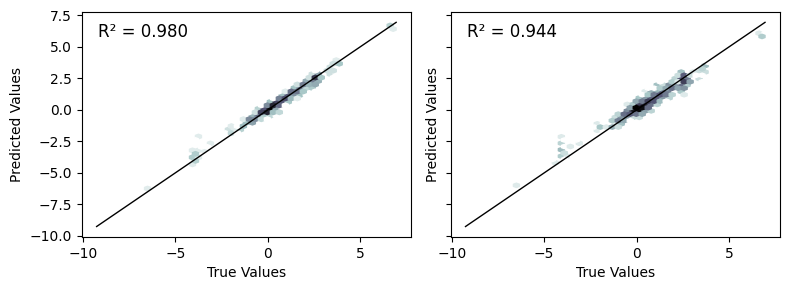

In [74]:
ylims = (y.min(), y.max())
xlims = (y.min(), y.max())

y_used = y[is_used]

# Calculate predictions without spatial effect
# Extract the spatial effect from the trace
spatial_effect = trace.posterior.f.mean(dim=['chain', 'draw']).values
mu_estimate = trace.posterior.mu.mean(dim=['chain', 'draw']).values

final_gdf_subset = final_gdf_subset.assign(residual=y_used - mu_estimate)

# Calculate R² for the full model
y_pred = mu_estimate
r_squared = 1 - np.var(y_used - y_pred) / np.var(y)
print(f"Full model R²: {r_squared:.4f}")

# Subtract spatial effect from full predictions to get predictions without spatial component
y_pred_no_spatial = mu_estimate - spatial_effect
r_squared_no_spatial = 1 - np.var(y_used - y_pred_no_spatial) / np.var(y_used)
print(f"R² without spatial effect: {r_squared_no_spatial:.4f}")

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# Plot full model predictions
axes[0].hexbin(y_used, y_pred, cmap="bone_r", bins='log', gridsize=50)
axes[0].plot([y_used.min(), y_used.max()], [y_used.min(), y_used.max()], 'k', lw=1, label='Ideal Fit')
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')
axes[0].text(x=0.05, y=0.95, s=f"R² = {r_squared:.3f}", transform=axes[0].transAxes,
             fontsize=12, verticalalignment='top')

# Plot predictions without spatial effect
axes[1].hexbin(y_used, y_pred_no_spatial, bins='log', cmap="bone_r", gridsize=50)
axes[1].plot([y_used.min(), y_used.max()], [y_used.min(), y_used.max()], 'k', lw=1, label='Ideal Fit')
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')
axes[1].text(x=0.05, y=0.95,s= f"R² = {r_squared_no_spatial:.3f}", transform=axes[1].transAxes,
            fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig(VISUALS_DIR / 'prediction_comparison.png', dpi=300)
plt.show()

# Calculate the proportion of variance explained by spatial effect
spatial_contribution = r_squared - r_squared_no_spatial
if SAVE_FIGURES:
    print(f"Proportion of variance explained by spatial effect: {spatial_contribution:.4f} ({spatial_contribution/r_squared:.1%} of total R²)")

### Plot of network overlaid on residuals

/tmp/ipykernel_1973035/1296674298.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_x, centroids_y = final_gdf_bbox.centroid.x.values, final_gdf_bbox.centroid.y.values


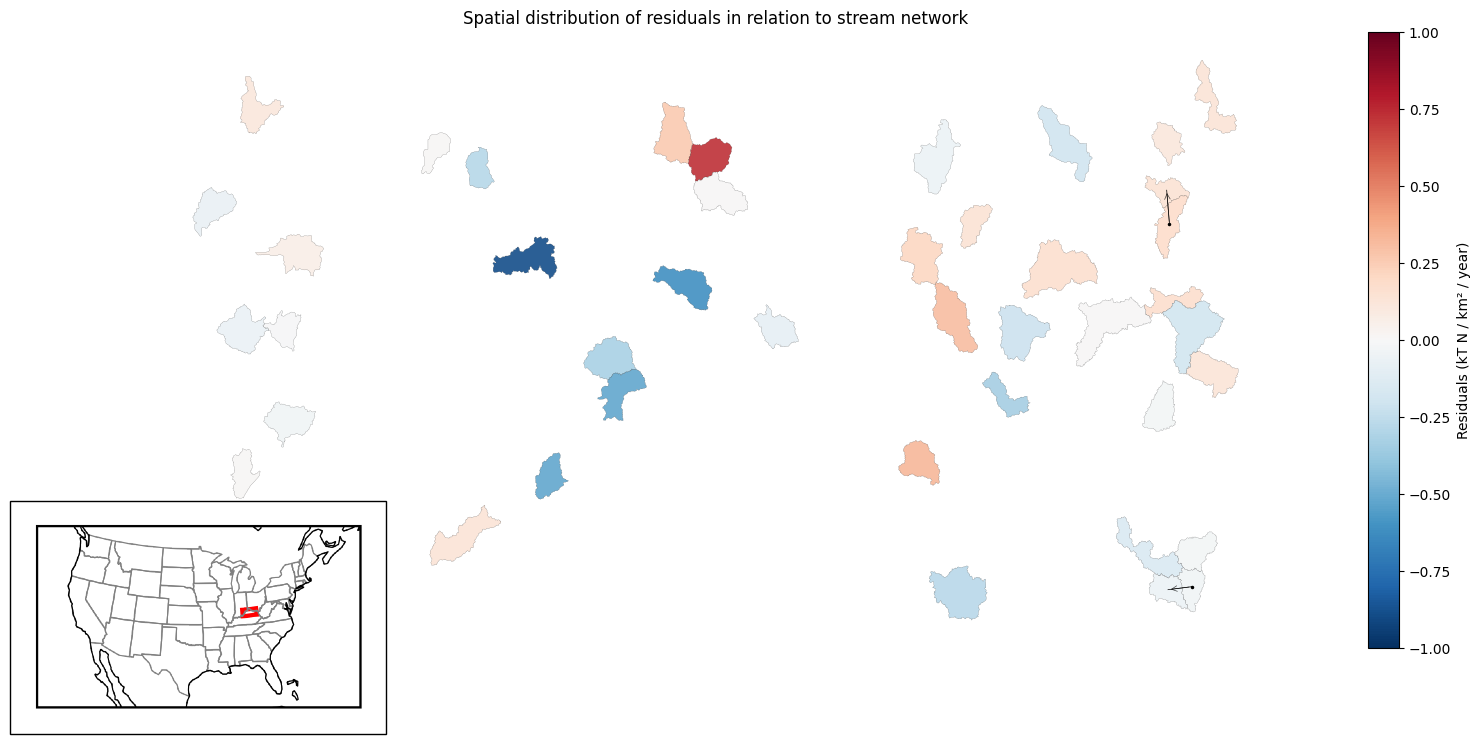

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np
import matplotlib.patches as mpatches

# Define the bounding box
bottom_lat = 38
top_lat = 39
left_lon = -86
right_lon = -83

# Filter the GeoDataFrame to the bounding box
# Fixing the slice syntax
final_gdf_bbox = final_gdf_subset.cx[left_lon:right_lon, bottom_lat:top_lat]

# Plot the residuals
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)

# Plot the GeoDataFrame
final_gdf_bbox.plot(
    ax=ax,
    column='residual',
    cmap='RdBu_r',
    legend=True,
    edgecolor='black',
    linewidth=0.1,
    alpha=0.9,
    vmin=-1,
    vmax=1,
    legend_kwds={'label': "Residuals (kT N / km² / year)"},
)
ax.set_title("Spatial distribution of residuals in relation to stream network")

# Get catchments in the bounding box
is_in_bbox = final_gdf.huc12.isin(final_gdf_bbox.huc12)
W_bbox = W[is_in_bbox.values][:, is_in_bbox.values]

# Get centroids of catchments in the bounding box
centroids_x, centroids_y = final_gdf_bbox.centroid.x.values, final_gdf_bbox.centroid.y.values

# Plot the stream network connections
for row, col in zip(*W_bbox.nonzero()):
    pt_x, pt_y = centroids_x[row], centroids_y[row]
    x_end, y_end = centroids_x[col], centroids_y[col]
    
    # Draw line between connected catchments
    ax.plot(
        [pt_x, x_end], [pt_y, y_end],  # Fixed: separate x and y coordinates into lists
        color='k', linewidth=0.5
    )
    
    # Add markers at catchment centroids
    ax.plot(pt_x, pt_y, marker='o', markersize=1.5, color='k')
    
    # Add arrow annotation
    ax.annotate("", xy=(x_end, y_end), xytext=(pt_x, pt_y),
            arrowprops=dict(arrowstyle="->", linewidth=0.5, alpha=0.7))
    
ax.axis('off')

# Create the inset map with cartopy projection
# Create a new figure for the inset to avoid projection conflicts
inset_fig = plt.figure(figsize=(2, 2))
inset_ax = inset_fig.add_subplot(111, projection=ccrs.AlbersEqualArea(
    central_longitude=-96, central_latitude=39))

# Add features to the inset map
inset_ax.add_feature(cfeature.STATES.with_scale('110m'), edgecolor='gray', linewidth=0.5)
inset_ax.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5)

# Set extent for USA map
inset_ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Draw a rectangle showing the extent of the main map
lon_min, lon_max, lat_min, lat_max = left_lon, right_lon, bottom_lat, top_lat
rect = mpatches.Rectangle(
    (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
    facecolor='none', edgecolor='red', linewidth=1.5, 
    transform=ccrs.PlateCarree())
inset_ax.add_patch(rect)

# Remove axis ticks and labels from the inset
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_path = VISUALS_DIR / 'usa_inset.png'
# Save the inset figure
inset_fig.savefig(inset_path, dpi=300, bbox_inches='tight', transparent=True)
plt.close(inset_fig)

# Add the inset as an image to the main figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
inset_img = plt.imread(inset_path)
imagebox = OffsetImage(inset_img, zoom=0.5)
ab = AnnotationBbox(imagebox, (0.05, 0.05), frameon=True, 
                    xycoords='axes fraction')
ax.add_artist(ab)

if SAVE_FIGURES:
    plt.savefig(VISUALS_DIR / 'bbox_residuals_with_stream_network.png', dpi=300, bbox_inches='tight')

In [ ]:
    01080203	{210DE1A2-B0E9-4857-BC54-7E813C47B317}	{511D2AC8-11BA-45FC-AB98-F69D693D4C44}	Watershed Boundary Dataset (WBD)	Natural Resources 